# 定义扰动功能模块

In [246]:
import numpy as np
import torch
from torch.autograd import Variable

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    

class PerturbationTool():
    def __init__(self, seed=0, epsilon=0.03137254901, num_steps=20, step_size=0.00784313725):
        self.epsilon = epsilon
        self.num_steps = num_steps
        self.step_size = step_size
        self.seed = seed
        np.random.seed(seed)

    def random_noise(self, noise_shape=[10, 3, 32, 32]):
        random_noise = torch.FloatTensor(*noise_shape).uniform_(-self.epsilon, self.epsilon).to(device)
        return random_noise

    def min_min_attack(self, images, labels, model, optimizer, criterion, random_noise=None, sample_wise=False):
        if random_noise is None:
            random_noise = torch.FloatTensor(*images.shape).uniform_(-self.epsilon, self.epsilon).to(device)
        
        perturb_img = Variable(images.data + random_noise, requires_grad=True)
        perturb_img = Variable(torch.clamp(perturb_img, 0, 1), requires_grad=True).reshape([1,3,32,32])
        perturb_img = perturb_img.cuda().detach()
        perturb_img.requires_grad = True

        eta = random_noise
        for _ in range(self.num_steps):
            opt = torch.optim.SGD([perturb_img], lr=1e-3)
            opt.zero_grad()
            model.zero_grad()
            if isinstance(criterion, torch.nn.CrossEntropyLoss):
                if hasattr(model, 'classify'):
                    model.classify = True
                logits = model(perturb_img.reshape([1,3,32,32]))
                logits = logits.view(-1, 1*10)
                if len(labels)==1:
                    labels = torch.tensor([lab for lab in labels for i in range(len(logits/10))]).cuda()
                else:
                    continue
                loss = criterion(logits, labels)
            else:
                logits, loss = criterion(model, perturb_img, labels, optimizer)
            perturb_img.retain_grad()
            loss.backward()

            eta = (self.step_size * perturb_img.grad.data.sign() * (-1)).reshape([3, 32, 32])
            perturb_img = Variable(perturb_img.data + eta, requires_grad=True).reshape([3, 32, 32])
            images = images.reshape([3, 32, 32])
            eta = torch.clamp(perturb_img.data - images.data, -self.epsilon, self.epsilon)
            perturb_img = Variable(images.data + eta, requires_grad=True)
            perturb_img = Variable(torch.clamp(perturb_img, 0, 255), requires_grad=True)

        return perturb_img, eta
    
    def min_max_attack(self, images, labels, model, optimizer, criterion, random_noise=None, sample_wise=False):
        if random_noise is None:
            random_noise = torch.FloatTensor(*images.shape).uniform_(-self.epsilon, self.epsilon).to(device)

        perturb_img = Variable(images.data + random_noise, requires_grad=True)
        perturb_img = Variable(torch.clamp(perturb_img, 0, 255), requires_grad=True).reshape([1,3,32,32])
        perturb_img = perturb_img.cuda().detach()
        perturb_img.requires_grad = True
        eta = random_noise
        for _ in range(self.num_steps):
            opt = torch.optim.SGD([perturb_img], lr=1e-3)
            opt.zero_grad()
            model.zero_grad()
            if isinstance(criterion, torch.nn.CrossEntropyLoss):
                logits = model(perturb_img.reshape([1,3,32,32]))
                logits = logits.view(-1, 1*10)
                if len(labels)==1:
                    labels = torch.tensor([lab for lab in labels for i in range(len(logits/10))]).cuda()
                else:
                    continue
                loss = criterion(logits, labels)
            else:
                logits, loss = criterion(model, perturb_img, labels, optimizer)
            loss.backward()

            eta = self.step_size * perturb_img.grad.data.sign().reshape([3, 32, 32])
            perturb_img = Variable(perturb_img.data + eta, requires_grad=True).reshape([3, 32, 32])
            images = images.reshape([3, 32, 32])
            eta = torch.clamp(perturb_img.data - images.data, -self.epsilon, self.epsilon)
            perturb_img = Variable(images.data + eta, requires_grad=True)
            perturb_img = Variable(torch.clamp(perturb_img, 0, 255), requires_grad=True)

        return perturb_img, eta

    def _patch_noise_extend_to_img(self, noise, image_size=[3, 32, 32], patch_location='center'):
        c, h, w = image_size[0], image_size[1], image_size[2]
        mask = np.zeros((c, h, w), np.float32)
        x_len, y_len = noise.shape[1], noise.shape[1]

        if patch_location == 'center' or (h == w == x_len == y_len):
            x = h // 2
            y = w // 2
        elif patch_location == 'random':
            x = np.random.randint(x_len // 2, w - x_len // 2)
            y = np.random.randint(y_len // 2, h - y_len // 2)
        else:
            raise('Invalid patch location')

        x1 = np.clip(x - x_len // 2, 0, h)
        x2 = np.clip(x + x_len // 2, 0, h)
        y1 = np.clip(y - y_len // 2, 0, w)
        y2 = np.clip(y + y_len // 2, 0, w)
        if type(noise) is np.ndarray:
            pass
        else:
            mask[:, x1: x2, y1: y2] = noise.cpu().numpy()
        return ((x1, x2, y1, y2), torch.from_numpy(mask).to(device))



In [265]:
root = '../datasets/'
BATCH_SIZE = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_POISON = 50

train_transform = [
    transforms.ToTensor()
]
test_transform = [
    transforms.ToTensor()
]
train_transform = transforms.Compose(train_transform)
test_transform = transforms.Compose(test_transform)

clean_train_dataset = datasets.CIFAR10(root, train=True, download=True, transform=train_transform)
clean_test_dataset = datasets.CIFAR10(root, train=False, download=True, transform=test_transform)

clean_train_loader = DataLoader(dataset=clean_train_dataset, batch_size=BATCH_SIZE,
                                shuffle=False, pin_memory=True,
                                drop_last=False, num_workers=12)
clean_test_loader = DataLoader(dataset=clean_test_dataset, batch_size=BATCH_SIZE,
                                shuffle=False, pin_memory=True,
                                drop_last=False, num_workers=12)

Files already downloaded and verified
Files already downloaded and verified


In [273]:
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms

import numpy as np
from tqdm import tqdm

from models.ResNet import ResNet18
from util import AverageMeter

import random
import matplotlib.pyplot as plt
import matplotlib

CLASS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
train_transform = [
        transforms.ToTensor()
    ]
train_transform = transforms.Compose(train_transform)

def find_similar_img(target, k=50):
    trainDataLoader = torch.utils.data.DataLoader(dataset=clean_train_dataset, batch_size=1)
    processBar = tqdm(trainDataLoader, unit='step')
    sims = {}
    for index, (trainImgs, labels) in enumerate(processBar):
        trainImgs = trainImgs.to(device)
        cos_sim = torch.nn.functional.cosine_similarity(target.flatten(), trainImgs.flatten(), dim=0)
        sims[index] = cos_sim
    sims = sorted(sims.items(), key=lambda x: x[1], reverse=True)
    # print(sims[:10])  # (9881, tensor(0.9158))
    # print(sims[0][0])  # 9881
    
    sim_group = []
    for i in range(k):
        sim_group.append(sims[i][0])

    return sim_group

def linear_interpolation(target_img, sim_id_group, alpha=0.5):
    target_img = target_img.cuda()
    ip_img = []
    sim_img = []
    trainDataLoader = torch.utils.data.DataLoader(dataset=clean_train_dataset, batch_size=1)
    processBar = tqdm(trainDataLoader, unit='step')
    for index, (trainImgs, labels) in enumerate(processBar):
        if index in sim_id_group:
            sim_img.append(trainImgs)
    for img in sim_img:
        img = img.cuda().reshape([32,32,3])
        interpolation = alpha * target_img + (1-alpha) * img
        ip_img.append(interpolation)
    ip_img = torch.tensor([img.cpu().detach().numpy() for img in ip_img]).cuda().float()
    return ip_img

def create_poison_data(new_imgs):
    poison_dataset = torch.tensor([img.cpu().detach().numpy() for img in new_imgs]).cuda()
    for i in range(len(poison_dataset)):
        poison_dataset.data[i] = torch.clamp(poison_dataset.data[i], 0, 255)
    return poison_dataset.cuda()



def train_new_poisoned_model(poison_dataset, MAX_EPOCH=20, BATCH_SIZE=128):
    model = ResNet18()
    model = model.cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1, weight_decay=0.0005, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0)

    unlearnable_loader = DataLoader(poison_dataset, BATCH_SIZE=BATCH_SIZE,
                                    shuffle=True, pin_memory=True,
                                    drop_last=False, num_workers=12)
    clean_train_dataset = datasets.CIFAR10(root, train=True, download=True, transform=train_transform)
    clean_loader = DataLoader(clean_train_dataset, BATCH_SIZE=BATCH_SIZE,
                                    shuffle=True, pin_memory=True,
                                    drop_last=False, num_workers=12)
    clean_test_dataset = datasets.CIFAR10(root, train=False, download=True, transform=test_transform)
    clean_test_loader = DataLoader(dataset=clean_test_dataset, BATCH_SIZE=BATCH_SIZE,
                                    shuffle=False, pin_memory=True,
                                    drop_last=False, num_workers=12)
    
    for epoch in range(MAX_EPOCH):
        model.train()
        acc_meter = AverageMeter()
        loss_meter = AverageMeter()
        pbar = tqdm([unlearnable_loader, clean_loader], total=len(unlearnable_loader, clean_loader))
        for images, labels in pbar:
            images, labels = images.cuda(), labels
            model.zero_grad()
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            
            _, predicted = torch.max(logits.data, 1)
            acc = (predicted == labels).sum().item()/labels.size(0)
            acc_meter.update(acc)
            loss_meter.update(loss.item())
            pbar.set_description("Acc %.4f Loss: %.4f" % (acc_meter.avg*100, loss_meter.avg))
        scheduler.step()
        # Eval
        model.eval()
        correct, total = 0, 0
        for i, (images, labels) in enumerate(clean_test_loader):
            images, labels = images.cuda(), labels.cuda()
            with torch.no_grad():
                logits = model(images)
                _, predicted = torch.max(logits.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        acc = correct / total
        tqdm.write('Clean Accuracy %.4f\n' % (acc*100))
        # Test target class
        target = torch.tensor(clean_test_dataset.data[8745]).to(device)
        with torch.no_grad():
            logits = model(target)
            _, predicted = torch.max(logits.data, 1)
            # print(CLASS[int(predicted)])
    return predicted




In [248]:
def generate_noise(base_model, criterion, optimizer, interpolation_imgs, intended_labels, MAX_ITERATION=10):
    noise = torch.zeros([len(interpolation_imgs), 3, 32, 32]).to(device)
    data_iter = iter(interpolation_imgs)
    target_labels = torch.tensor([intended_labels,]).to(device)
    condition = True
    train_idx = 0

    while condition:
        # optimize theta for M steps
        base_model.train()
        for param in base_model.parameters():
            param.requires_grad = True
        for j in range(0, 10):
            try:
                images = next(data_iter)
            except:
                train_idx = 0
                data_iter = iter(interpolation_imgs)
                images = next(data_iter)
            
            for i, _ in enumerate(images):
                # Update noise to images
                images = images.reshape([1, 3, 32, 32])
                images += noise[train_idx]
                train_idx += 1 if train_idx != len(interpolation_imgs)-1 else 0
            images, target_labels = images.cuda(), target_labels.cuda()
            base_model.zero_grad()
            optimizer.zero_grad()
            logits = base_model(images)
            loss = criterion(logits, target_labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(base_model.parameters(), 5.0)
            optimizer.step()
        
        # Perturbation over entire interpolation_imgs
        idx = 0
        for param in base_model.parameters():
            param.requires_grad = False
        
        perturb_img_list = []
        for i, (images) in tqdm(enumerate(interpolation_imgs), total=len(interpolation_imgs)):
            perturb_img, eta = noise_generator.min_min_attack(images, target_labels, base_model, optimizer, criterion)
            perturb_img_list.append(perturb_img.clone().detach().cpu())
        for i, delta in enumerate(eta):
            noise[i] = delta.clone().detach().cpu()
            
            
        # Eval stop condition
        eval_idx, total, correct = 0, 0, 0
        for i, (images) in enumerate(interpolation_imgs):
            for i, _ in enumerate(images):
                # Update noise to images
                images = images + noise[eval_idx].reshape([32,32,3])
                eval_idx += 1 if eval_idx != len(interpolation_imgs)-1 else 0
            images, target_labels = images.cuda(), target_labels.cuda()
            with torch.no_grad():
                logits = base_model(images.reshape([1,3,32,32]))
                _, predicted = torch.max(logits.data, 1)
                total += target_labels.size(0)
                correct += (predicted == target_labels).sum().item()
        acc = correct / total
        print('Accuracy %.4f' % (acc*100))
        if acc > 0.9500:
            condition=False     
            
    perturb_img_list = torch.tensor([img.cpu().detach().numpy() for img in perturb_img_list]).cuda().float()
    noise = torch.tensor([img.cpu().detach().numpy() for img in noise]).cuda().float()
    
    return perturb_img_list, noise

# 初始化设置

In [267]:
clean_target = (torch.tensor(clean_test_dataset.data[8745]).to(device).float())/255
clean_label = torch.tensor([5,]).to(device)

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

base_model = ResNet18()
base_model = base_model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=base_model.parameters(), lr=0.1, weight_decay=0.0005, momentum=0.9)

noise_generator = PerturbationTool(epsilon=0.03137254901960784, num_steps=20, step_size=0.0031372549019607846)

# 从训练集中找出相似度较高的图像

In [270]:
# print(clean_target)
similar_imgs = find_similar_img(clean_target, NUM_POISON)

100%|██████████| 50000/50000 [00:22<00:00, 2218.78step/s]


In [274]:
interpolation_imgs = linear_interpolation(target, similar_imgs, alpha=0.9)
# print(interpolation_imgs)

100%|██████████| 50000/50000 [00:11<00:00, 4316.62step/s]


# 线性插值，创建毒物集并加入扰动

In [279]:
raw_dataset = create_poison_data(interpolation_imgs)
raw_dataset /= 255
perturb_img_list, noise = generate_noise(base_model, criterion, optimizer, raw_dataset, intended_labels=torch.tensor(3), MAX_ITERATION=10)

100%|██████████| 50/50 [00:09<00:00,  5.24it/s]


Accuracy 100.0000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


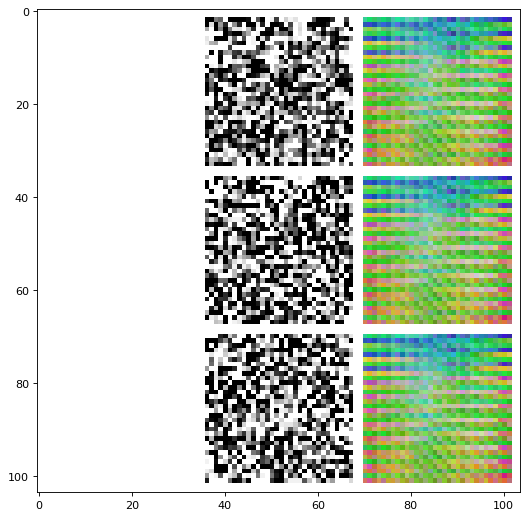

In [283]:
import random
import matplotlib.pyplot as plt
import matplotlib

def imshow(img):
    fig = plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def get_pairs_of_imgs(idx):
    clean_img = interpolation_imgs.data[idx].reshape([3,32,32])
    unlearnable_img = perturb_img_list.data[idx]

    x = noise[idx]
    x_min = torch.min(x)
    x_max = torch.max(x)
    noise_norm = (x - x_min) / (x_max - x_min)
    noise_norm = torch.clamp(noise_norm, 0, 1)
    # print([clean_img.cuda(), noise_norm, unlearnable_img])
    return [clean_img.cuda(), noise_norm, unlearnable_img]
    
selected_idx = [0,1,2]
img_grid = []
for idx in selected_idx:
    img_grid += get_pairs_of_imgs(idx)
    

imshow(torchvision.utils.make_grid(torch.stack(img_grid), nrow=3, pad_value=255))

In [282]:
predict = train_new_poisoned_model(poison_dataset)
print('Target 8745[dog] is classified as type {}'.format(CLASS[int(predict)]))

TypeError: __init__() got an unexpected keyword argument 'BATCH_SIZE'